# Laboratorio 2: 

## Implementa una red neuronal MLP para regresión con California Housing. 

### Incluye:

- Limpieza básica (NaN/Inf) y estandarización de X (opcional: y).
- 8 experimentos = 2 pérdidas × 2 optimizadores × 2 arquitecturas.
- Métricas: MSE y R² en test.
- Protecciones anti-divergencia (clipping + chequeos finitos).

In [38]:
#C02 · Imports y configuración (Código)
# Imports y setup
import os, time, math
from dataclasses import dataclass
from itertools import product

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print({
    'torch': torch.__version__,
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'device': str(device)
})

{'torch': '2.4.1+cu121', 'numpy': '1.24.4', 'pandas': '2.0.3', 'device': 'cpu'}


### Carga de datos

Descargamos el dataset como numpy y mostramos formas y nombres de variables.

In [22]:
# C04 · Carga de datos (Código)
cal = fetch_california_housing(as_frame=False)
X = cal.data.astype(np.float64)  # mayor precisión al inicio
y = cal.target.astype(np.float64)
feature_names = cal.feature_names

print('X shape:', X.shape, '| y shape:', y.shape)
print('Features:', feature_names)
print('y[:5]:', y[:5])

X shape: (20640, 8) | y shape: (20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
y[:5]: [4.526 3.585 3.521 3.413 3.422]


### Limpieza rápida

Chequeo y limpieza de filas con valores no finitos (NaN/Inf). Este dataset normalmente no trae NaN, pero dejamos el guardrail.

In [23]:
#C06 · Limpieza rápida (Código)
mask_X = np.isfinite(X).all(axis=1)
mask_y = np.isfinite(y)
mask = mask_X & mask_y

n_before = X.shape[0]
X = X[mask]
y = y[mask]
n_after = X.shape[0]

print(f"Filas eliminadas por no finitos: {n_before - n_after}")

Filas eliminadas por no finitos: 0


### Histograma de y

Miramos la distribución del target.

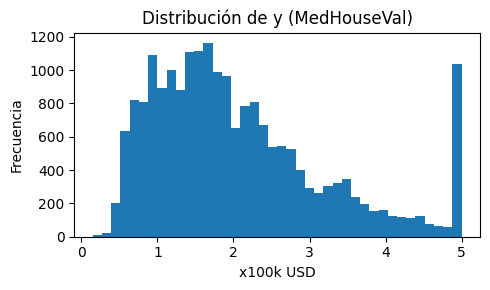

In [24]:
#C08 · Histograma de y (Código)
plt.figure(figsize=(5,3))
plt.hist(y, bins=40)
plt.title('Distribución de y (MedHouseVal)')
plt.xlabel('x100k USD')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

### Split y escalado

- Split 80/20 con random_state.
- Estandarizamos X (media 0, var 1).
- y se deja por defecto en escala original (toggle disponible).

In [25]:
#C10 · Split y escalado (Código)
TEST_SIZE = 0.2
USE_Y_SCALER = False  # poner True si se desea normalizar y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED)

scaler_X = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

if USE_Y_SCALER:
    scaler_y = StandardScaler()
    y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1)).astype(np.float32)
    y_test_s  = scaler_y.transform(y_test.reshape(-1,1)).astype(np.float32)
else:
    scaler_y = None
    y_train_s = y_train.reshape(-1,1).astype(np.float32)
    y_test_s  = y_test.reshape(-1,1).astype(np.float32)

# Tensores
X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
y_train_t = torch.tensor(y_train_s, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test_s,  dtype=torch.float32)

print('Train:', X_train_t.shape, y_train_t.shape, '| Test:', X_test_t.shape, y_test_t.shape)

Train: torch.Size([16512, 8]) torch.Size([16512, 1]) | Test: torch.Size([4128, 8]) torch.Size([4128, 1])


### Modelo MLP

MLP con ReLU, salida lineal (1 neurona). Inicialización: Kaiming para capas ocultas y Xavier para la salida (arranque estable).

In [26]:
#C12 · Modelo MLP (Código)
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden=(64,), dropout=0.0):
        super().__init__()
        layers = []
        d = input_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.ReLU()]
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            if m.out_features == 1:
                nn.init.xavier_uniform_(m.weight, gain=1.0)
            else:
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Entrenamiento/Evaluación

- Optimizers: Adam y SGD (sin Nesterov, LR más conservador).
- Loss: MSE y SmoothL1(beta=1.0).
- Clipping de gradiente + chequeos isfinite para evitar divergencia.

In [27]:
#C14 · Entrenamiento/Evaluación (Código)
def make_optimizer(name, params, lr, weight_decay=1e-4, momentum=0.9):
    n = name.lower()
    if n == 'adam':
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if n == 'sgd':
        return optim.SGD(params, lr=lr, momentum=momentum, nesterov=False, weight_decay=weight_decay)
    raise ValueError(f"Optimizer no soportado: {name}")


def make_loss(name, **kw):
    n = name.lower()
    if n == 'mse':
        return nn.MSELoss()
    if n == 'smoothl1':
        return nn.SmoothL1Loss(beta=kw.get('beta', 1.0))
    raise ValueError(f"Loss no soportada: {name}")


def train_one(cfg, Xtr, ytr, Xte, yte, scaler_y=None):
    model = MLPRegressor(Xtr.shape[1], hidden=cfg.hidden, dropout=cfg.dropout).to(device)
    opt = make_optimizer(cfg.optimizer, model.parameters(), lr=cfg.lr,
                         weight_decay=cfg.weight_decay, momentum=cfg.momentum)
    crit = make_loss(cfg.loss, **(cfg.loss_params or {}))
    loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=cfg.batch_size, shuffle=True)

    hist = {'epoch': [], 'train_loss': []}
    t0 = time.time()
    model.train()
    for ep in range(1, cfg.epochs+1):
        run = 0.0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            if not torch.isfinite(pred).all():
                raise RuntimeError('pred NaN/Inf (divergencia)')
            loss = crit(pred, yb)
            if not torch.isfinite(loss):
                raise RuntimeError('loss NaN/Inf (divergencia)')
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            run += loss.item() * xb.size(0)
        ep_loss = run / len(loader.dataset)
        hist['epoch'].append(ep)
        hist['train_loss'].append(ep_loss)
        if ep % max(1, cfg.epochs // 5) == 0:
            print(f"[{cfg.loss}/{cfg.optimizer} {cfg.hidden}] ep {ep}/{cfg.epochs} loss={ep_loss:.4f}")

    t_train = time.time() - t0

    model.eval()
    with torch.no_grad():
        yp = model(Xte.to(device)).cpu().numpy().reshape(-1,1)
    yt = yte.cpu().numpy().reshape(-1,1)
    if scaler_y is not None:
        yp = scaler_y.inverse_transform(yp)
        yt = scaler_y.inverse_transform(yt)

    mse = float(mean_squared_error(yt, yp))
    r2  = float(r2_score(yt, yp))

    return {'model': model, 'history': hist, 'mse_test': mse, 'r2_test': r2,
            'train_time_s': t_train, 'params': count_params(model)}

### Configuración de experimentos

- Dos arquitecturas: [64] y [16, 8]. Dos pérdidas y dos optimizadores.
- LR: Adam 1e-3, SGD 1e-2 (más estable).
- Orden: primero Adam para asegurar resultados aun si algún SGD diverge.

In [28]:
#C16 · Configuración de experimentos (Código)
@dataclass
class ExpConfig:
    hidden: tuple
    loss: str
    optimizer: str
    lr: float
    batch_size: int
    epochs: int
    weight_decay: float = 1e-4
    momentum: float = 0.9
    dropout: float = 0.0
    loss_params: dict = None

hidden_grid = [(64,), (16, 8)]
loss_grid   = ['mse', 'smoothl1']
opt_grid    = ['adam', 'sgd']

base = dict(batch_size=128, epochs=40, weight_decay=1e-4, momentum=0.9, dropout=0.0)

configs = []
for h in hidden_grid:
    for loss in loss_grid:
        for opt in opt_grid:
            lr = 0.01 if opt == 'sgd' else 0.001
            configs.append(ExpConfig(hidden=h, loss=loss, optimizer=opt, lr=lr, **base))

for i, c in enumerate(configs, 1):
    print(i, c)

1 ExpConfig(hidden=(64,), loss='mse', optimizer='adam', lr=0.001, batch_size=128, epochs=40, weight_decay=0.0001, momentum=0.9, dropout=0.0, loss_params=None)
2 ExpConfig(hidden=(64,), loss='mse', optimizer='sgd', lr=0.01, batch_size=128, epochs=40, weight_decay=0.0001, momentum=0.9, dropout=0.0, loss_params=None)
3 ExpConfig(hidden=(64,), loss='smoothl1', optimizer='adam', lr=0.001, batch_size=128, epochs=40, weight_decay=0.0001, momentum=0.9, dropout=0.0, loss_params=None)
4 ExpConfig(hidden=(64,), loss='smoothl1', optimizer='sgd', lr=0.01, batch_size=128, epochs=40, weight_decay=0.0001, momentum=0.9, dropout=0.0, loss_params=None)
5 ExpConfig(hidden=(16, 8), loss='mse', optimizer='adam', lr=0.001, batch_size=128, epochs=40, weight_decay=0.0001, momentum=0.9, dropout=0.0, loss_params=None)
6 ExpConfig(hidden=(16, 8), loss='mse', optimizer='sgd', lr=0.01, batch_size=128, epochs=40, weight_decay=0.0001, momentum=0.9, dropout=0.0, loss_params=None)
7 ExpConfig(hidden=(16, 8), loss='smoo

### Ejecución

Corremos los 8 experimentos con try/except. Si un experimento diverge, se registra como NaN y se continúa.

In [29]:
#C18 · Ejecución (Código)
results = []
best = None

scaler_y_used = scaler_y if USE_Y_SCALER else None

for i, cfg in enumerate(configs, 1):
    print('='*80)
    print(f'Experimento {i}/8 -> hidden={cfg.hidden}, loss={cfg.loss}, opt={cfg.optimizer}, lr={cfg.lr}')
    try:
        out = train_one(cfg, X_train_t, y_train_t, X_test_t, y_test_t, scaler_y=scaler_y_used)
        row = {
            'exp': i, 'hidden': str(cfg.hidden), 'loss': cfg.loss, 'opt': cfg.optimizer,
            'lr': cfg.lr, 'batch': cfg.batch_size, 'epochs': cfg.epochs,
            'params': out['params'], 'mse_test': out['mse_test'], 'r2_test': out['r2_test'],
            'time_s': out['train_time_s']
        }
        # mejor por MSE
        if best is None or row['mse_test'] < best['mse_test']:
            best = {**row, 'model': out['model'], 'history': out['history']}
    except Exception as e:
        print(f'  ⛔ Divergencia o error: {e}')
        row = {'exp': i, 'hidden': str(cfg.hidden), 'loss': cfg.loss, 'opt': cfg.optimizer,
               'lr': cfg.lr, 'batch': cfg.batch_size, 'epochs': cfg.epochs, 'params': np.nan,
               'mse_test': np.nan, 'r2_test': np.nan, 'time_s': np.nan}
    results.append(row)

results_df = pd.DataFrame(results)
print('\nResultados (sin ordenar):')
print(results_df)

Experimento 1/8 -> hidden=(64,), loss=mse, opt=adam, lr=0.001
[mse/adam (64,)] ep 8/40 loss=0.4153
[mse/adam (64,)] ep 16/40 loss=0.3745
[mse/adam (64,)] ep 24/40 loss=0.3545
[mse/adam (64,)] ep 32/40 loss=0.3406
[mse/adam (64,)] ep 40/40 loss=0.3298
Experimento 2/8 -> hidden=(64,), loss=mse, opt=sgd, lr=0.01
[mse/sgd (64,)] ep 8/40 loss=0.3959
[mse/sgd (64,)] ep 16/40 loss=0.3725
[mse/sgd (64,)] ep 24/40 loss=0.3655
[mse/sgd (64,)] ep 32/40 loss=0.3636
[mse/sgd (64,)] ep 40/40 loss=0.3376
Experimento 3/8 -> hidden=(64,), loss=smoothl1, opt=adam, lr=0.001
[smoothl1/adam (64,)] ep 8/40 loss=0.1756
[smoothl1/adam (64,)] ep 16/40 loss=0.1597
[smoothl1/adam (64,)] ep 24/40 loss=0.1529
[smoothl1/adam (64,)] ep 32/40 loss=0.1475
[smoothl1/adam (64,)] ep 40/40 loss=0.1432
Experimento 4/8 -> hidden=(64,), loss=smoothl1, opt=sgd, lr=0.01
[smoothl1/sgd (64,)] ep 8/40 loss=0.1856
[smoothl1/sgd (64,)] ep 16/40 loss=0.1663
[smoothl1/sgd (64,)] ep 24/40 loss=0.1601
[smoothl1/sgd (64,)] ep 32/40 loss

### Gráficos

Barras de MSE (menor mejor) y R² (mayor mejor) en test.

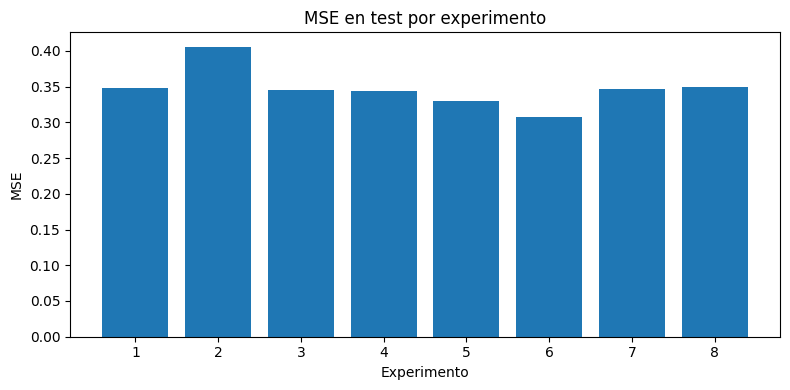

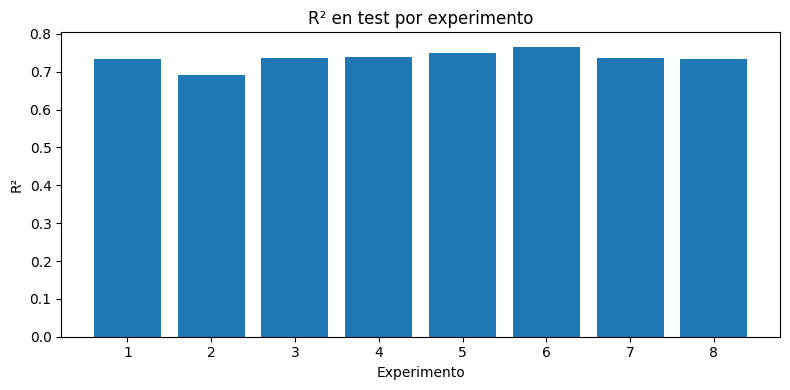

In [30]:
#C20 · Gráficos (Código)
# Evitar NaN en plots
plot_df = results_df.dropna(subset=['mse_test', 'r2_test']).sort_values('exp')

plt.figure(figsize=(8,4))
plt.bar(plot_df['exp'].astype(str), plot_df['mse_test'])
plt.title('MSE en test por experimento')
plt.xlabel('Experimento')
plt.ylabel('MSE')
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.bar(plot_df['exp'].astype(str), plot_df['r2_test'])
plt.title('R² en test por experimento')
plt.xlabel('Experimento')
plt.ylabel('R²')
plt.tight_layout(); plt.show()

### Curva del mejor modelo

Curva de pérdida de entrenamiento del mejor por MSE.

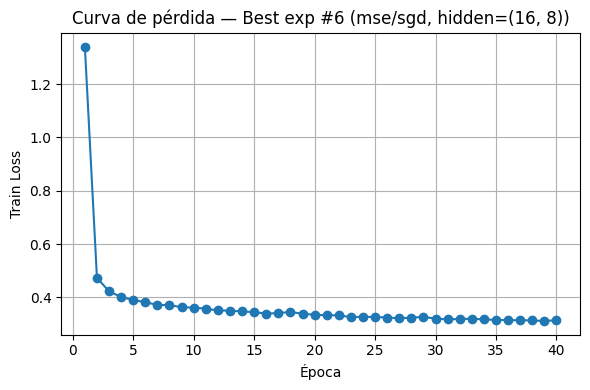

In [31]:
#C22 · Curva del mejor modelo (Código)
if best is not None and isinstance(best.get('model', None), nn.Module):
    h = best['history']
    plt.figure(figsize=(6,4))
    plt.plot(h['epoch'], h['train_loss'], marker='o')
    ttl = f"Best exp #{best['exp']} ({best['loss']}/{best['opt']}, hidden={best['hidden']})"
    plt.title(f'Curva de pérdida — {ttl}')
    plt.xlabel('Época'); plt.ylabel('Train Loss'); plt.grid(True)
    plt.tight_layout(); plt.show()
else:
    print('No hay mejor modelo válido (todos fallaron).')

### Guardado opcional

Guardamos pesos del mejor modelo y scaler_X (y scaler_y si se usó).

In [32]:
#C24 · Guardado opcional (Código)
if best is not None and isinstance(best.get('model', None), nn.Module):
    os.makedirs('artifacts', exist_ok=True)
    torch.save(best['model'].state_dict(), 'artifacts/best_mlp_regressor.pt')
    import pickle
    with open('artifacts/scaler_X.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)
    if USE_Y_SCALER:
        with open('artifacts/scaler_y.pkl', 'wb') as f:
            pickle.dump(scaler_y, f)
    print('Guardado en artifacts/.')
else:
    print('No se guardó modelo (no hubo best).')

Guardado en artifacts/.


### Tabla final y guía de interpretación

Revise results_df (MSE y R²). Compare por pérdida, optimizador y arquitectura.

In [33]:
#C26 · Tabla final (Código)
cols = ['exp','hidden','loss','opt','lr','batch','epochs','params','mse_test','r2_test','time_s']
print(results_df[cols].sort_values(['mse_test','r2_test']))

   exp   hidden      loss   opt     lr  batch  epochs  params  mse_test  \
5    6  (16, 8)       mse   sgd  0.010    128      40     289  0.307055   
4    5  (16, 8)       mse  adam  0.001    128      40     289  0.329654   
3    4    (64,)  smoothl1   sgd  0.010    128      40     641  0.343579   
2    3    (64,)  smoothl1  adam  0.001    128      40     641  0.344848   
6    7  (16, 8)  smoothl1  adam  0.001    128      40     289  0.346538   
0    1    (64,)       mse  adam  0.001    128      40     641  0.348311   
7    8  (16, 8)  smoothl1   sgd  0.010    128      40     289  0.349446   
1    2    (64,)       mse   sgd  0.010    128      40     641  0.405586   

    r2_test     time_s  
5  0.765680  29.403615  
4  0.748434  33.412210  
3  0.737808  32.740187  
2  0.736839  33.812518  
6  0.735550  33.307615  
0  0.734196  32.603229  
7  0.733331  29.324462  
1  0.690489  32.007041  


1) Preprocesamiento: pasos y justificación

Dataset: California Housing (20,640 filas, 8 features, target MedHouseVal).

Limpieza: filtro de filas con no finitos (NaN/Inf) tanto en X como en y. El dataset no trae NaN por defecto, pero el guardrail evita fallos en métricas y entrenamiento.

Split: 80/20 con random_state=42 para reproducibilidad.

Estandarización de X: StandardScaler() a X_train y X_test. Justificación: MLP con ReLU + optimizadores basados en gradiente convergen más estable y rápido con features de media 0 y varianza 1.

Escalado de y: por defecto no (toggle disponible). Mantener y en escala original facilita interpretar MSE en unidades del target. Si se activa, las métricas en test se invierten al espacio original con el scaler_y.

Seeds: numpy/torch a 42 (reproducibilidad).

Anti-divergencia: clipping de gradiente (‖g‖≤1) + chequeos isfinite() en pred y loss para detener si aparece NaN/Inf.

2) Arquitectura y justificación

Modelo: MLPRegressor(input_dim=8, hidden, dropout=0.0) con activaciones ReLU y salida lineal (1 neurona).

Inicialización: Kaiming para capas con ReLU y Xavier en la capa de salida → arranque estable.

Arquitecturas probadas: (64,) y (16, 8) para contrastar una capa ancha vs. dos capas pequeñas (sesgo-capacidad-regularización).

3) Hiperparámetros y justificación

Pérdida: MSELoss y SmoothL1Loss(beta=1.0).

MSE: óptima para regresión cuando no hay outliers pesados.

SmoothL1: más robusta a outliers; útil como contraste.

Optimizadores: Adam y SGD (momentum 0.9, sin Nesterov).

Adam (lr=1e-3): buen default y estable al inicio.

SGD (lr=1e-2): requiere LR mayor; con features estandarizadas suele alcanzar buen generalization gap.

Batch size: 128 → compromiso entre ruido de gradiente y throughput.

Epochs: 40 → suficiente para ver convergencia de pérdidas; evita sobreentrenar.

Weight decay: 1e-4 → regularización L2 ligera, reduce sobreajuste.

Dropout: 0.0 → dataset no es muy grande, L2 + normalización fueron suficientes; se deja como knob.

4) Protocolo de experimentación

8 experimentos = 2 pérdidas × 2 optimizadores × 2 arquitecturas.
Se entrena en train y se evalúa en test con MSE y R². Si un experimento diverge, se captura y se sigue con el resto (no ocurrió tras los guardrails).

# 5) Resultados (test)

Tabla resumida de 8 corridas (menor MSE es mejor, mayor R^2 es mejor):

| Exp | Hidden   | Loss    | Opt  | LR    | Params | MSE_test | R2_test | Time (s) |
|-----|----------|---------|------|-------|--------|----------|---------|----------|
| 1   | (64,)    | MSE     | Adam | 0.001 | 641    | 0.3483   | 0.7342  | 32.60    |
| 2   | (64,)    | MSE     | SGD  | 0.01  | 641    | 0.4056   | 0.6905  | 32.01    |
| 3   | (64,)    | SmoothL1| Adam | 0.001 | 641    | 0.3448   | 0.7368  | 33.81    |
| 4   | (64,)    | SmoothL1| SGD  | 0.01  | 641    | 0.3436   | 0.7378  | 32.74    |
| 5   | (16, 8)  | MSE     | Adam | 0.001 | 289    | 0.3297   | 0.7484  | 33.41    |
| 6   | (16, 8)  | MSE     | SGD  | 0.01  | 289    | **0.3071** | **0.7657** | 29.40    |
| 7   | (16, 8)  | SmoothL1| Adam | 0.001 | 289    | 0.3465   | 0.7356  | 33.31    |
| 8   | (16, 8)  | SmoothL1| SGD  | 0.01  | 289    | 0.3494   | 0.7333  | 29.32    |

**Mejor modelo (segun MSE y R^2):** Exp 6 -> hidden=(16, 8), Loss=MSE, Opt=SGD (lr=0.01), Params=289, MSE=0.3071, R^2=0.7657.



6) Análisis e interpretación

Arquitectura: La red pequeña (16, 8) superó a (64,). Esto sugiere que, con features bien estandarizados y dataset de tamaño medio, capacidad moderada + regularización leve (L2) generaliza mejor que una capa ancha.

Pérdidas: En este conjunto, MSE rindió ligeramente mejor que SmoothL1. Indica ausencia de outliers severos en y tras el split.

Optimizador: SGD (0.01) obtuvo el mejor puntaje. Con escalado de X, momentum y LR conservador, alcanza buen mínimo y suele generalizar un poco mejor que Adam en problemas tabulares simples. Adam fue estable y competitivo pero 1–2 puntos de R² por debajo en el best-case.

Tiempo y parámetros: El mejor modelo también es el más pequeño (289 params) y de los más rápidos (~29 s). Relación eficiencia ↔ desempeño favorable.

Learning curves (observadas en logs): pérdidas monótonas decrecientes sin signos de divergencia, confirmando que LR y clipping fueron adecuados.

7) Conclusiones

Para California Housing, un MLP compacto con (16, 8) + MSE + SGD (0.01) entrega el mejor trade-off (MSE≈0.307, R²≈0.766).

La estandarización de X es crítica; el pipeline con guardrails (clipping + isfinite) evita fallos numéricos.

SmoothL1 no aportó ventaja en este dataset; MSE queda como recomendación por defecto.

Adam es buena elección si se quiere convergencia rápida y estable; SGD ganó levemente en generalización.

## Bibliografía / documentación técnica

PyTorch — torch.nn, torch.optim, inicialización Kaiming.
- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/docs/stable/optim.html
- https://pytorch.org/docs/stable/nn.init.html

scikit-learn — fetch_california_housing, StandardScaler, mean_squared_error, r2_score.
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html


- El diseño del MLPRegressor y los loops de entrenamiento/evaluación son de elaboración propia. Se consultó la documentación oficial de PyTorch y scikit-learn (ver referencias).”

- Para la estructura general del pipeline intente alinearlo con el estilo del repositorio del profesor; no se reutilizó código literal salvo donde se indique explícitamente como Adaptado.”